In [1]:
import zarr
import allel
import numpy as np
import pandas as pd
import fsspec
import gcsfs
import dask.array as da

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.cm
import matplotlib.colors
import seaborn as sns
%matplotlib inline

In [3]:
from ag3 import release_data

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
v3 = release_data()

In [5]:
gcsfs.core.client_config['installed']['client_id'] = '160816776314-7h1p2h6bqhe77vs1su4rr22fblso9dre.apps.googleusercontent.com'
gcsfs.core.client_config['installed']['client_secret'] = 'SrJUwD58yKgViyJtw-NP2sz8'

In [6]:
# create a GCSFileSystem just for the purpose of authentication
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# create another one with those credentials
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials, cache_timeout=0)

In [7]:
# this is where the aim data live on disk: UPDATE TO RELEASE DIR.
aim_path = 'gs://vo_agam_production/aim_results/{sample_set}.zarr'

## Overview

For gamb_colu vs arab, given large number of AIMs, lets be more discerning *and* filter them.

- exclude to AIMs that are at AF >0.8 in arabiensis
- downsample, and downsample to a much greater extent on X.

For gamb_vs_colu keep the set as found.

### get A. arabiensis loci

In [8]:
chromosomes = "2R", "2L", "3R", "3L", "X"

In [9]:
# loop through all samplesets and chromosomes
# the only purpose of this section is to downsample the arabiensis / gamb_colu AIMs
gambcolu_arab_loc = {}
for chrom in chromosomes:
    ac_arabiensis = []
    ac_gambiae = []
    for sample_set in v3.all_wild_sample_sets:

        aim_store = fsspec.get_mapper(aim_path.format(sample_set=sample_set))
        aim_data = zarr.open_consolidated(aim_store)
        
        metadata = v3.load_sample_set_metadata(sample_set)
        sample_names = metadata.index.tolist()

        # not all samples described in AIM data pass QC
        aim_sample_ids = aim_data["gambcolu_vs_arab"][chrom]["SAMPLES"][:].tolist()
        
        ix_passed_samples = [aim_sample_ids.index(s) for s in sample_names]
        
        subpops = metadata.groupby(["species_gambcolu_arabiensis"]).indices

        g = allel.GenotypeArray(da.from_zarr(aim_data["gambcolu_vs_arab"][chrom]["GT_AIM"]).compute()).take(ix_passed_samples, axis=1)

        ac = g.count_alleles_subpops(subpops)

        # catch errors when sampleset contains none of given species
        try:
            ac_arabiensis.append(ac["arabiensis"])
        except KeyError:
            pass

        try:
            ac_gambiae.append(ac["gamb_colu"])
        except KeyError:
            pass

    ac_gambcolu = allel.AlleleCountsArray(np.stack(ac_gambiae, axis=2).sum(axis=2))
    alt_freq_gamb_colu = ac_gambcolu.to_frequencies()[:, 1]

    ac_arab = allel.AlleleCountsArray(np.stack(ac_arabiensis, axis=2).sum(axis=2))
    alt_freq_arab = ac_arab.to_frequencies()[:, 1]

    if chrom == "X":
        gambcolu_arab_loc[chrom] = (alt_freq_arab >= 0.8) & (np.random.random(alt_freq_arab.shape[0]) > 0.95)
    else:
        gambcolu_arab_loc[chrom] = (alt_freq_arab >= 0.8) & (np.random.random(alt_freq_arab.shape[0]) > 0.5)

In [10]:
for k, v in gambcolu_arab_loc.items():
    print(k, v.sum())

2R 767
2L 895
3R 1063
3L 1180
X 1251


### get A. gambiae / col loci

In [11]:
# loop through all samplesets and chromosomes
# the only purpose of this section is to downsample the arabiensis / gamb_colu AIMs
gamb_colu_loc = {}
for chrom in chromosomes:
    ac_arabiensis = []
    ac_gambiae = []
    sample_set = "AG1000G-UG"
    aim_store = fsspec.get_mapper(aim_path.format(sample_set=sample_set))
    
    aim_data = zarr.open_consolidated(aim_store)
        
    gamb_colu_loc[chrom] = np.ones(aim_data["gamb_vs_colu"][chrom]["GT_AIM"].shape[0], dtype="bool")

In [12]:
for k, v in gamb_colu_loc.items():
    print(k, v.sum())

2R 58
2L 95
3R 57
3L 30
X 489


In [13]:
# now compress the AIMs by the keep list, and plot.
# this to be functionized with optional parameter which is downsample.

## inputs: samplesets, chromosomes, width_ratios, aim_desc ie gambcolu_vs_arab, gambcolu_arab_loc, cmap, path, figsize.
def create_aim_multiplot(sample_sets, chromosomes, aim_desc, path, aim_downsample_loc, qstring=None, width_ratios=None, figsize=(20, 15), cmap="Dark2", dpi=200):
    
    # loop through all samplesets.
    fig = plt.figure(figsize=figsize)

    if qstring is None:
        hr = [v3.load_sample_set_metadata(sample_set).shape[0] for sample_set in sample_sets]
    else:
        # handle sample_sets where selected samples = 0.
        hr = [v3.load_sample_set_metadata(sample_set).query(qstring).shape[0] for sample_set in sample_sets]
        sample_sets = [s for s, size in zip(sample_sets, hr) if size > 0]
        hr = [size for size in hr if size > 0]
        
    wr = [aim_downsample_loc[chrom].sum() for chrom in chromosomes]
  
    gs = GridSpec(nrows=len(sample_sets), ncols=len(chromosomes), height_ratios=hr, width_ratios=wr)

    # setup colour map
    if isinstance(cmap, str):
        cmap = matplotlib.cm.get_cmap(name=cmap, lut=None)
    elif isinstance(cmap, list):
        cmap = matplotlib.colors.ListedColormap(cmap)

    boundaries = [-.1, 0.9, 1.1, 2.1]
    norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    
    for i, sample_set in enumerate(sample_sets):

        aim_store = fsspec.get_mapper(aim_path.format(sample_set=sample_set))
        aim_data = zarr.open_consolidated(aim_store)

        metadata = v3.load_sample_set_metadata(sample_set)
        if qstring is not None:
            metadata = metadata.query(qstring)
        
        sample_names = metadata.index
        
        for j, chrom in enumerate(chromosomes):

            # not all samples described in AIM data pass QC
            aim_sample_ids = aim_data[aim_desc][chrom]["SAMPLES"][:].tolist()
            ix_passed_samples = [aim_sample_ids.index(s) for s in sample_names]
            
            aim_gt = da.from_zarr(aim_data[aim_desc][chrom]["GT_AIM"]).compute()
            

            g = allel.GenotypeArray(aim_gt.compress(aim_downsample_loc[chrom], axis=0)).take(ix_passed_samples, axis=1)
            
            assert g.shape[1] == metadata.shape[0], "Genotypes not contiguous with metadata"

            nalt = g.to_n_alt()
            
            # sort by n alt alleles.
            count_alt_alleles = nalt.sum(axis=0)

            ix = np.argsort(count_alt_alleles)
            nalt_sorted = np.take(nalt, ix, axis=1)
                        
            ax = fig.add_subplot(gs[i, j])
            
            ax.pcolormesh(nalt_sorted.T, cmap=cmap, norm=norm)
            ax.set_yticks([])
            ax.set_xticks([])
            if chrom == "2R":
                ax.set_ylabel(sample_set, rotation=0, horizontalalignment="right", verticalalignment="center")
                
            # if this is the last sample set...
            if sample_set == sample_sets[-1]:
                ax.set_xlabel(chrom, rotation=0, horizontalalignment="center", verticalalignment="top")
                
    fig.savefig(path, dpi=dpi)

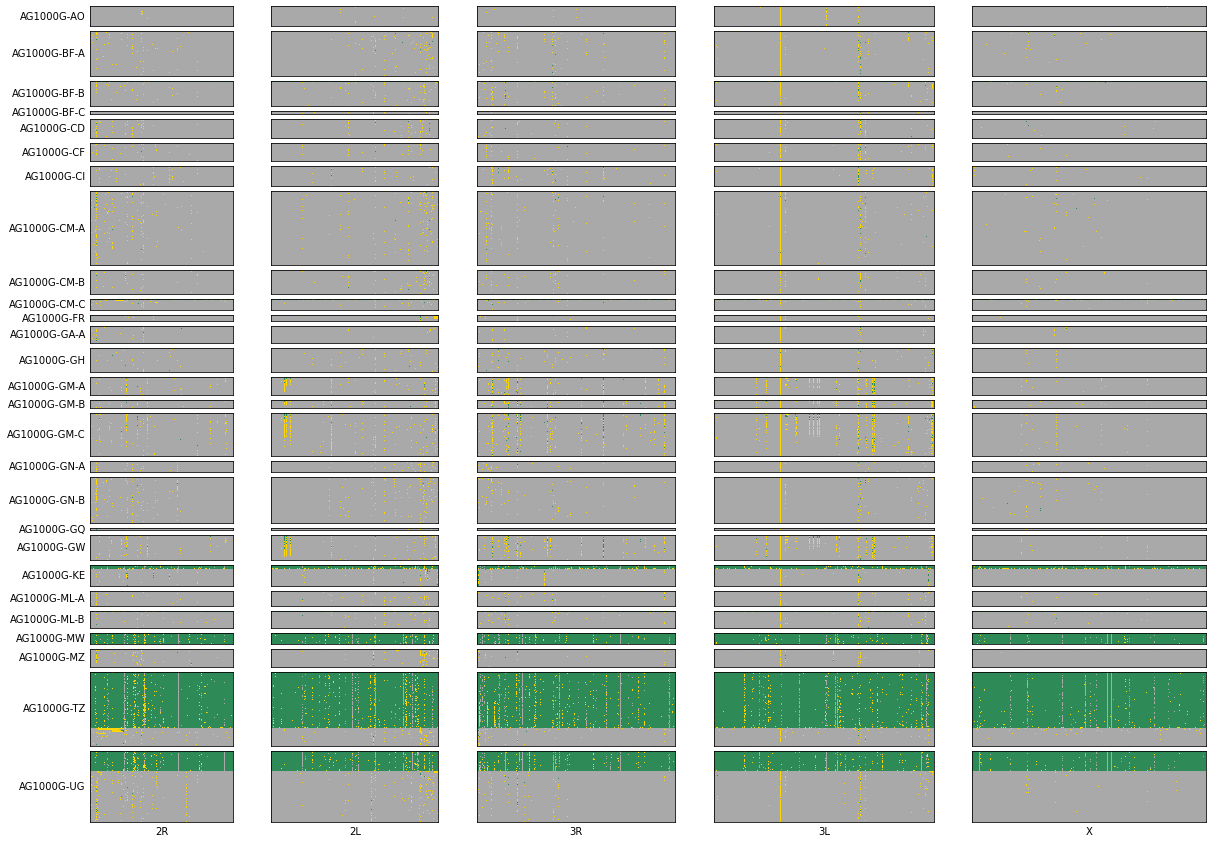

In [14]:
create_aim_multiplot(
    sample_sets=v3.all_wild_sample_sets, 
    #sample_sets=["AG1000G-UG", "AG1000G-TZ"],
    chromosomes=chromosomes,
    aim_desc="gambcolu_vs_arab", 
    cmap=['darkgray', 'gold', 'seagreen'],
    path="../content/images/aim/gambcolu_vs_arabiensis_aim.png",
    aim_downsample_loc=gambcolu_arab_loc,
    dpi=300)

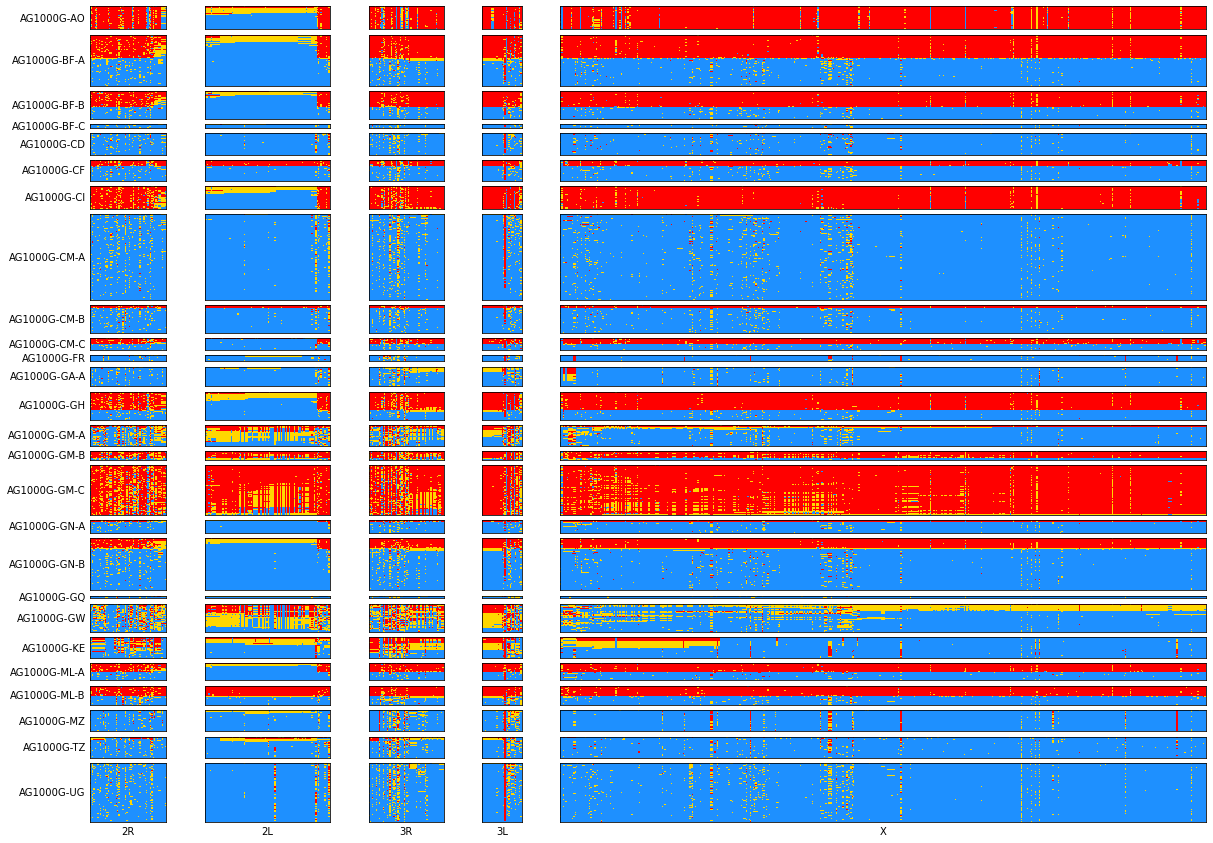

In [15]:
create_aim_multiplot(
    sample_sets=v3.all_wild_sample_sets, 
    chromosomes=chromosomes,
    aim_desc="gamb_vs_colu", 
    cmap=['dodgerblue', 'gold', 'red'],
    path="../content/images/aim/gamb_vs_colu_aim.png",
    aim_downsample_loc=gamb_colu_loc,
    qstring="species_gambcolu_arabiensis == 'gamb_colu'",
    dpi=300)

In [16]:
## Dive into this TZ region

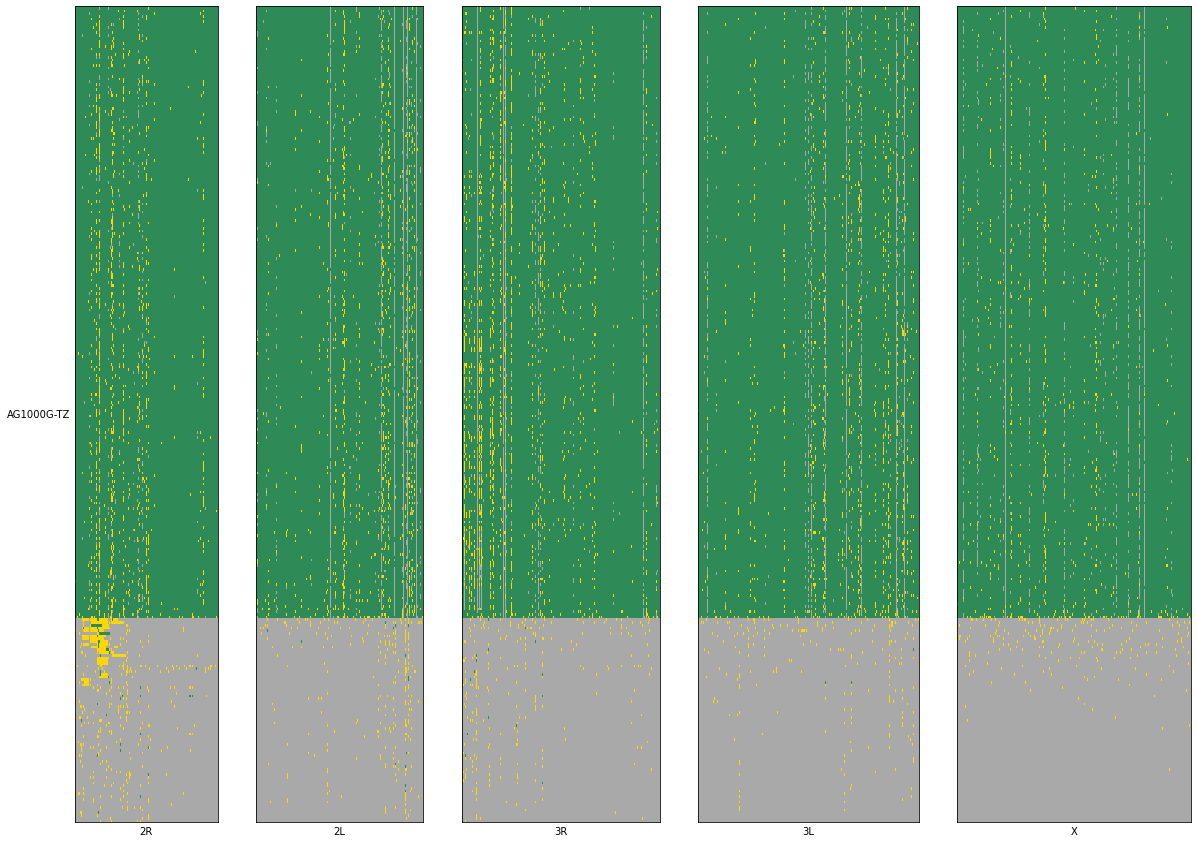

In [17]:
create_aim_multiplot(
    sample_sets=["AG1000G-TZ"],
    chromosomes=chromosomes,
    aim_desc="gambcolu_vs_arab", 
    cmap=['darkgray', 'gold', 'seagreen'],
    path="../content/images/aim/gambcolu_vs_arabiensis_aim_TZ.png",
    aim_downsample_loc=gambcolu_arab_loc,
    dpi=300)

## where do these aims fall? 

In [18]:
aim_store = fsspec.get_mapper(aim_path.format(sample_set="AG1000G-TZ"))
aim_data = zarr.open_consolidated(aim_store)

metadata = v3.load_sample_set_metadata("AG1000G-TZ").query("species_gambcolu_arabiensis == 'gamb_colu'")
sample_names = metadata.index
        
# not all samples described in AIM data pass QC
aim_sample_ids = aim_data["gambcolu_vs_arab"]["2R"]["SAMPLES"][:].tolist()
ix_passed_samples = [aim_sample_ids.index(s) for s in sample_names]
            
aim_gt = da.from_zarr(aim_data["gambcolu_vs_arab"]["2R"]["GT_AIM"]).compute()
pos = allel.SortedIndex(aim_data["gambcolu_vs_arab"]["2R"]["POS"])

In [19]:
g = allel.GenotypeArray(aim_gt).take(ix_passed_samples, axis=1)
            
assert g.shape[1] == metadata.shape[0], "Genotypes not contiguous with metadata"
nalt = g.to_n_alt()            

In [20]:
sum_alt_alleles_by_snp = nalt.sum(axis=1)

In [21]:
rolling_median = allel.moving_statistic(sum_alt_alleles_by_snp, np.median, size=20, step=5)
rolling_median_pos = allel.moving_statistic(pos, np.median, size=20, step=5)

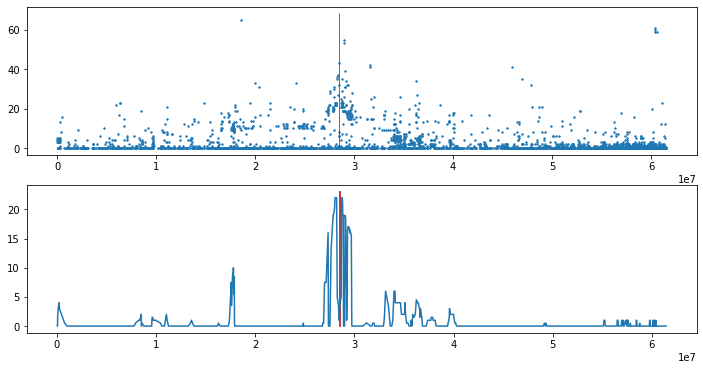

In [22]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 6))

ax1, ax2 = axes
ax1.scatter(pos, sum_alt_alleles_by_snp, s=2)
ax2.plot(rolling_median_pos, rolling_median)

GSTE_LOC = [28_480_576, 28_505_816]
start, end = GSTE_LOC[0], GSTE_LOC[1] - GSTE_LOC[0]


for ax in [ax1, ax2]:
    ax.broken_barh([[start, end]], [0, ax.get_ylim()[1]], color="firebrick", alpha=0.8)